In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import sys
import urllib
import zipfile
import statsmodels.formula.api as smf
import scipy
import scipy.stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
urllib.urlretrieve('https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD',os.getenv('PUIDATA')+
                   '/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')

In [ ]:
urllib.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip',os.getenv("PUIDATA") + "/Manhattan/mn_mappluto_16v2.zip")

In [ ]:
shp = zipfile.ZipFile(os.getenv("PUIDATA") + "/Manhattan/mn_mappluto_16v2.zip")
shp.extractall(os.getenv("PUIDATA") + '/Manhattan/')

In [8]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")


from pandas.tools.plotting import scatter_matrix

# sfig = scatter_matrix (nrg, s=300, figsize=(50,50), diagonal='kde')

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

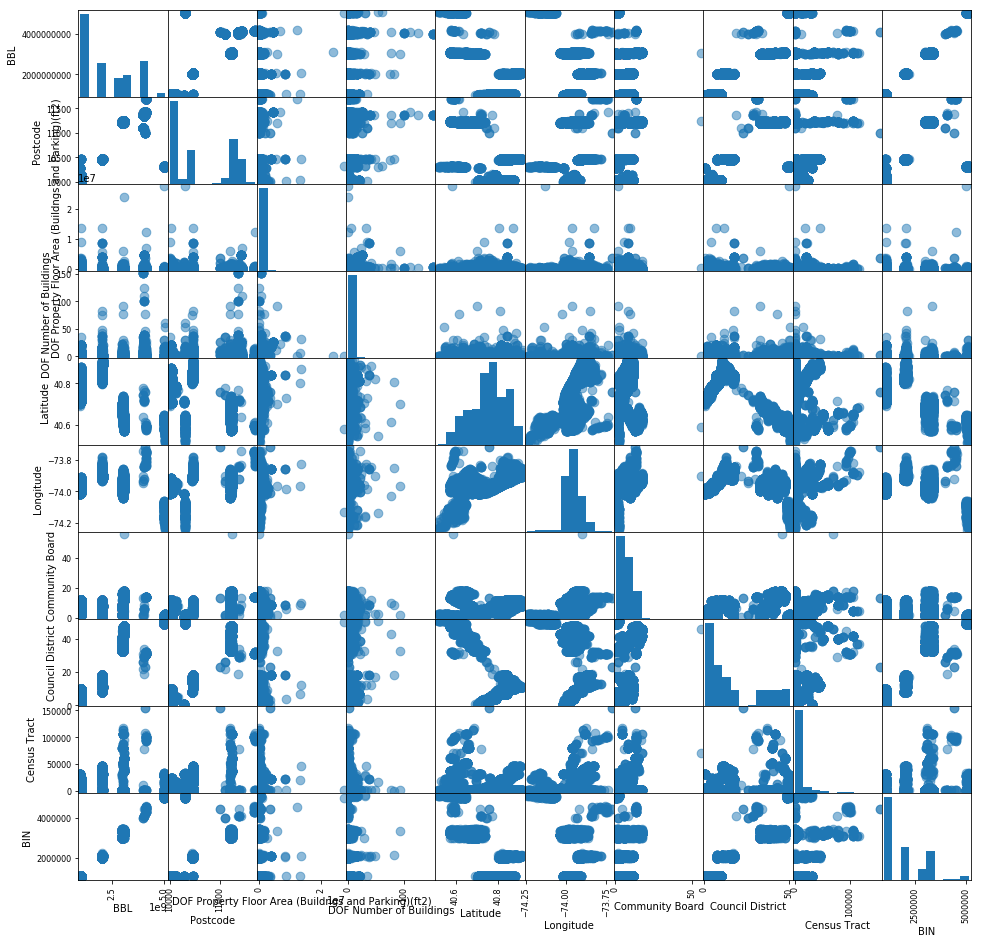

In [3]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

In [10]:
nrg.columns

Index([u'BBL', u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BIN', u'NTA'],
      dtype=

In [11]:
bsize=bsize[['UnitsRes','UnitsTotal','YearBuilt','BBL']]
nrg = nrg[['Weather Normalized Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft\xc2\xb2)','BBL','DOF Number of Buildings']]



In [12]:
nrg = nrg.rename(columns={'Weather Normalized Site EUI(kBtu/ft2)' : 'EUI', 'Reported Property Floor Area (Building(s)) (ft\xc2\xb2)' : 'floorspace'})

In [14]:
nrg['EUI'] = pd.to_numeric(nrg['EUI'],errors='coerce')
nrg['floorspace'] = pd.to_numeric(nrg['floorspace'],errors='coerce')
bsize['UnitsRes'] = pd.to_numeric(bsize['UnitsRes'],errors='coerce')
bsize['UnitsTotal'] = pd.to_numeric(bsize['UnitsTotal'],errors='coerce')
bsize['YearBuilt'] = pd.to_numeric(bsize['YearBuilt'],errors='coerce')
bsize['BBL'] = pd.to_numeric(bsize['BBL'],errors='coerce')

In [17]:
print(nrg['EUI'].astype(float))
indx = np.isnan(nrg['EUI']).sum()

for i in range(3):
    indx = np.isnan(nrg.iloc[:,i]).sum()
    print ("NRG column %s"%i, "invalid entries changed to NaN %d"%sum(indx))

Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     123.8
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
13804      NaN
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: EUI, dtype: float64
NRG column 0 invalid entries changed to NaN 6

In [19]:
# BBL values are in similar format for both dataframes so merge is easy

(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [20]:
bblnrgdata=pd.merge(nrg,bsize).dropna()
bblnrgdata.shape

(4047, 7)

In [22]:
bblnrgdata.head(3)

,EUI,floorspace,BBL,DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
2,123.8,330000.0,1.013110e+09,1.0,0,56,1977
15,122.4,59468.0,1.007660e+09,1.0,0,8,1912
16,115.9,364000.0,1.008150e+09,1.0,0,24,1954


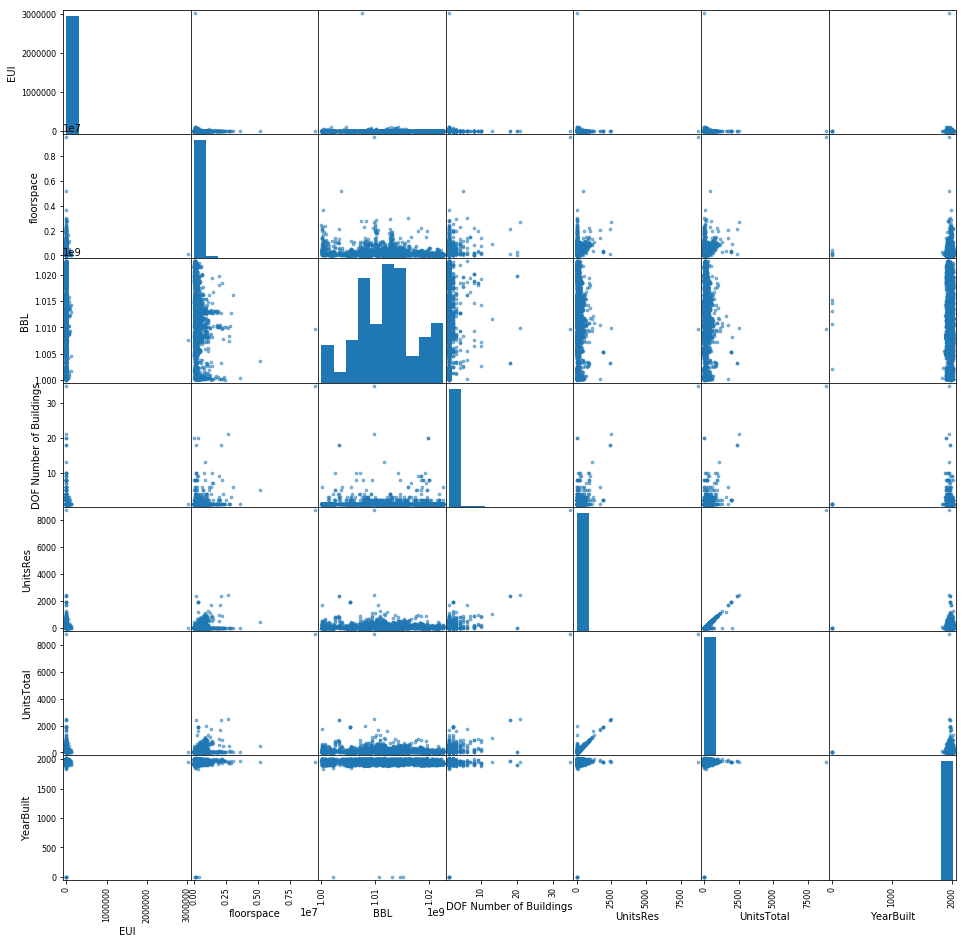

In [24]:
scatter_matrix (bblnrgdata, s=30, figsize=(16,16));

## Figure: Scatter Matrix of Merged Dataset

In [28]:
bblnrgdata['total_energy']=bblnrgdata.floorspace*bblnrgdata.EUI
bblnrgdata.head(3)

,EUI,floorspace,BBL,DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt,total_energy
2,123.8,330000.0,1.013110e+09,1.0,0,56,1977,40854000.0
15,122.4,59468.0,1.007660e+09,1.0,0,8,1912,7278883.2
16,115.9,364000.0,1.008150e+09,1.0,0,24,1954,42187600.0


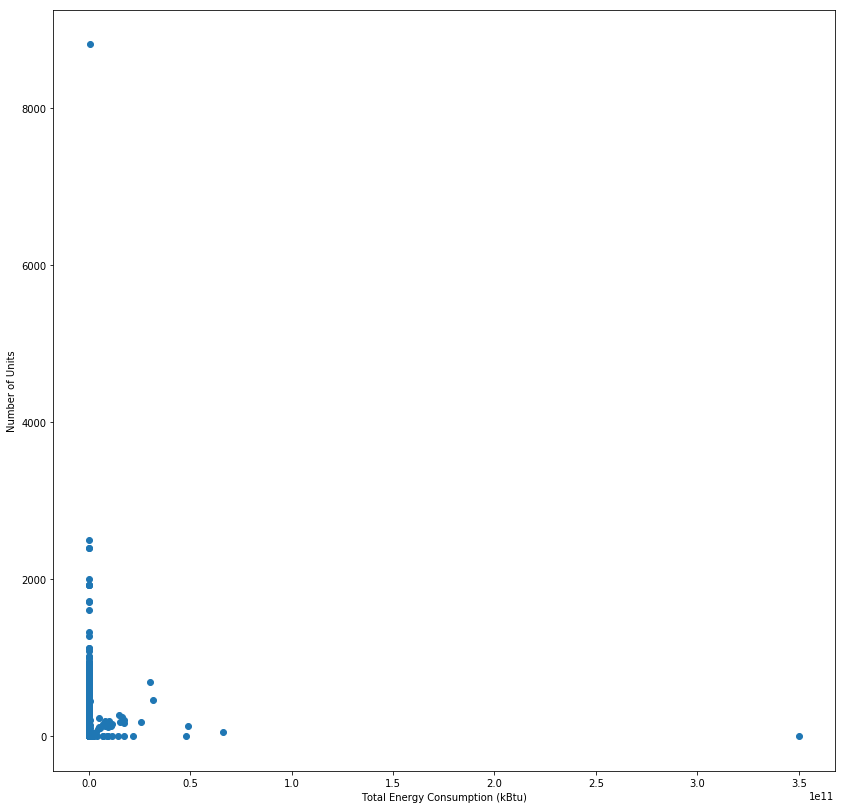

In [31]:
pl.figure(figsize=[14,14])
pl.scatter(bblnrgdata['total_energy'],bblnrgdata['UnitsTotal'])
pl.xlabel('Total Energy Consumption (kBtu)')
pl.ylabel('Number of Units')

## Figure: Scatter of energy consumption (kBtu) against housing units per building

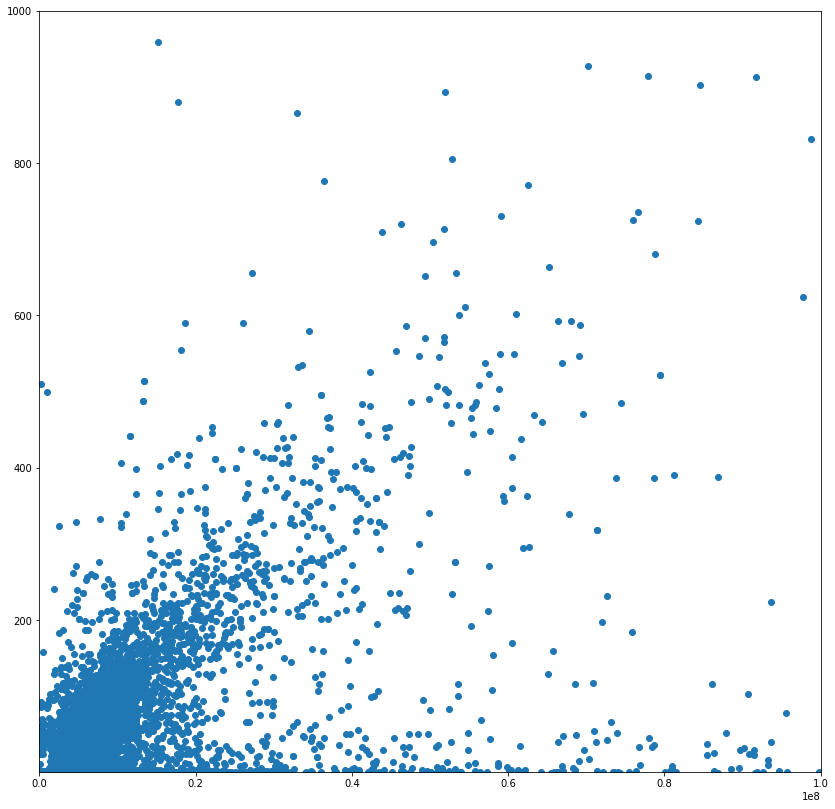

In [43]:
pl.figure(figsize=[14,14])
pl.scatter(bblnrgdata['total_energy'],bblnrgdata['UnitsTotal'])
pl.xlim(1000,1e8)
pl.ylim(1,1000);

## Figure: Scatter of energy consumption (kBtu) against housing units per building scaled to show detail

In [45]:

bblnrgdataCut = bblnrgdata[(bblnrgdata.total_energy > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [50]:
print(shape(bblnrgdata))
print(shape(bblnrgdataCut))


(4047, 8)
(3454, 8)


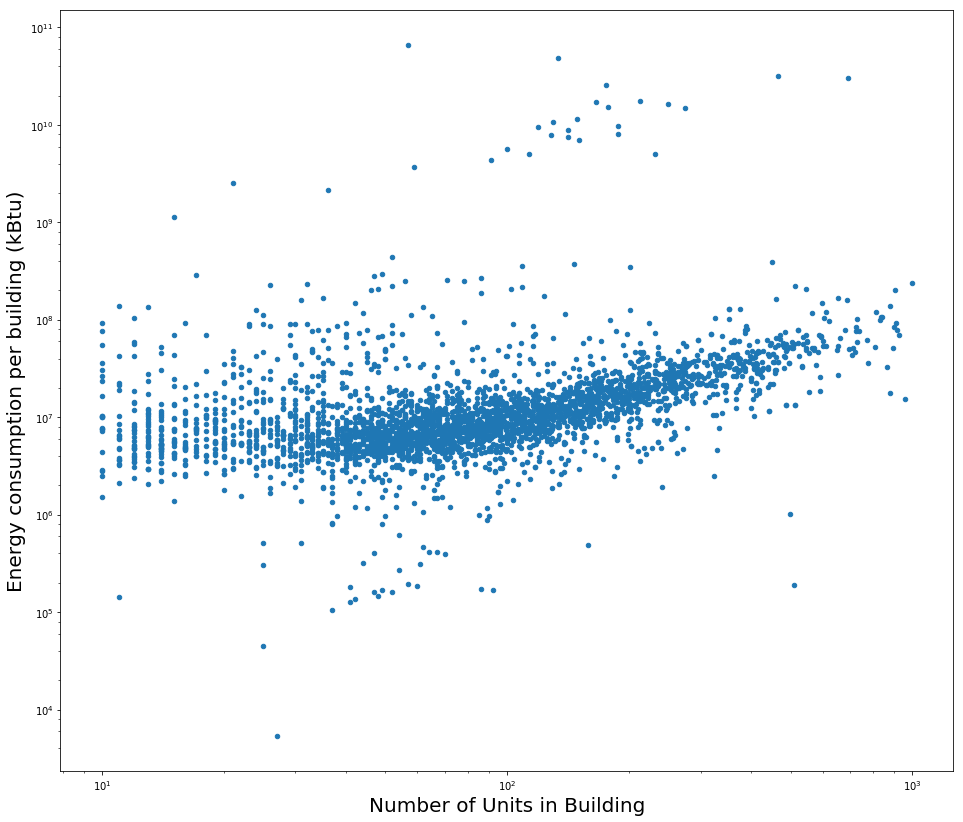

In [52]:
ax = bblnrgdataCut.plot(kind='scatter', y='total_energy', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)


In [ ]:
### 1. Fit a line to units vs energy

In [69]:
bblnrgdataCut['log_units'] = np.log10(bblnrgdataCut['UnitsTotal'])
bblnrgdataCut['log_energy'] = np.log10(bblnrgdataCut['total_energy'])

lm = smf.ols(formula='log_energy~log_units',data=bblnrgdataCut).fit()
lm.summary()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     716.3
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          1.52e-143
Time:                        23:01:10   Log-Likelihood:                -2060.7
No. Observations:                3454   AIC:                             4125.
Df Residuals:                    3452   BIC:                             4138.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.0599      0.037    162.827      0.000         5.987     6.133
log_units      0.5119      0.019     26.763      0.000         0.474     0.549
==============================================================================
Omnibus:                     1899.500   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40558.514
Skew:                           2.161   Prob(JB):                         0.00
Kurtosis:                      19.222   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ax = bblnrgdataCut.plot(kind='scatter', y='total_energy', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

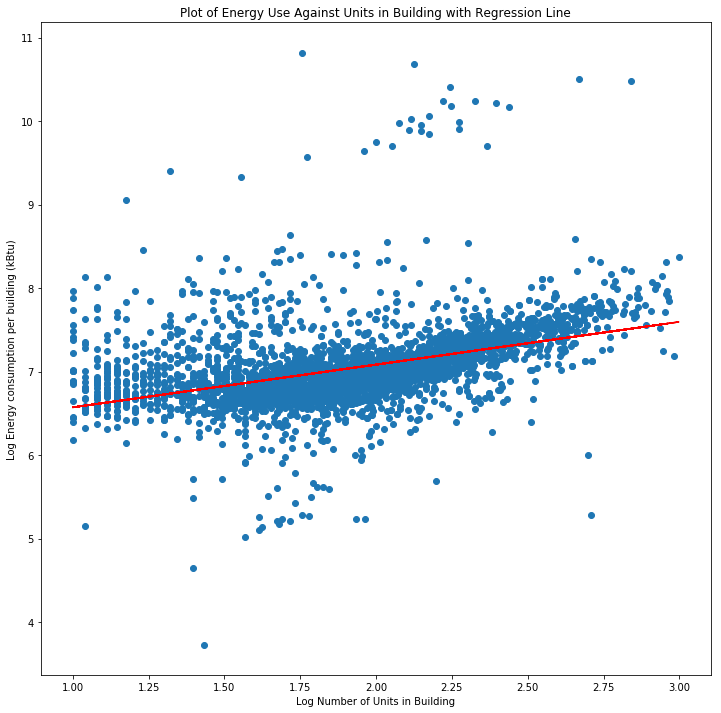

In [79]:
fitted_plot = pl.figure(figsize=(12,12))
ax = fitted_plot.add_subplot(111)
ax.scatter(bblnrgdataCut['log_units'],bblnrgdataCut['log_energy'])
ax.plot(bblnrgdataCut['log_units'],lm.predict(),'r')
ax.set_title("Plot of Energy Use Against Units in Building with Regression Line")
ax.set_xlabel("Log Number of Units in Building")
ax.set_ylabel("Log Energy consumption per building (kBtu)")


In [ ]:
### 2. Fit a line to energy vs units

In [77]:
lm1 = smf.ols(formula='log_units~log_energy',data=bblnrgdataCut).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_units   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     716.3
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          1.52e-143
Time:                        23:08:35   Log-Likelihood:                -1331.9
No. Observations:                3454   AIC:                             2668.
Df Residuals:                    3452   BIC:                             2680.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.4557      0.088     -5.152      0.000        -0.629    -0.282
log_energy     0.3357      0.013     26.763      0.000         0.311     0.360
==============================================================================
Omnibus:                      145.387   Durbin-Watson:                   1.389
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.652
Skew:                          -0.513   Prob(JB):                     2.91e-36
Kurtosis:                       3.289   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

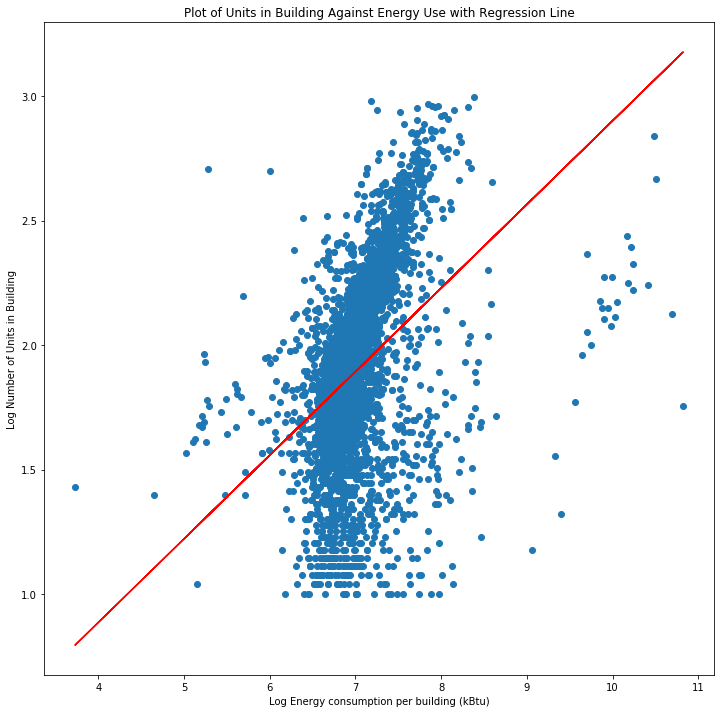

In [78]:
fitted_plot = pl.figure(figsize=(12,12))
ax = fitted_plot.add_subplot(111)
ax.scatter(bblnrgdataCut['log_energy'],bblnrgdataCut['log_units'])
ax.plot(bblnrgdataCut['log_energy'],lm1.predict(),'r')
ax.set_title("Plot of Units in Building Against Energy Use with Regression Line")
ax.set_xlabel("Log Energy consumption per building (kBtu)")
ax.set_ylabel("Log Number of Units in Building")

### 3. Evaluate which is better by calculating the chi-square

In [80]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [81]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured quantities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['floorspace'])**2 +\
                (bblnrgdataCut['EUI']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log

In [93]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.total_energy / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [92]:
print ("Chi2 for Energy vs Units: ",
chi2(bblnrgdataCut['log_energy'], lm.predict(), errorsInLogNrg))

print ("Chi2 for Units vs Energy: ",
chi2(bblnrgdataCut['log_units'], lm1.predict(), errorsInLogUnits))


Chi2 for Energy vs Units:  3.16368454975e+12
Chi2 for Units vs Energy:  373988.15293


__ Interpretation__  The chi-square values are high for both but this reflects the large number of observations
and hence the many degrees of freedom. The value for Energy Vs. Units is higher, indicating
that this is the superior model.

### 4. Fit a polynomial model to the data

Fit a 2nd degree polynomial to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is  $y = ax^2 + bx + c$ .

In [105]:
poly_model = smf.ols(formula='log_energy~I(log_units**2)+log_units',data=bblnrgdataCut).fit()
poly_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_energy   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     521.8
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          1.02e-198
Time:                        23:52:16   Log-Likelihood:                -1930.0
No. Observations:                3454   AIC:                             3866.
Df Residuals:                    3451   BIC:                             3884.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             8.0951      0.129     62.913      0.000         7.843     8.347
I(log_units ** 2)     0.5791      0.035     16.469      0.000         0.510     0.648
log_units            -1.7062      0.136    -12.552      0.000        -1.973    -1.440
==============================================================================
Omnibus:                     2064.394   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56783.468
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                      22.302   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

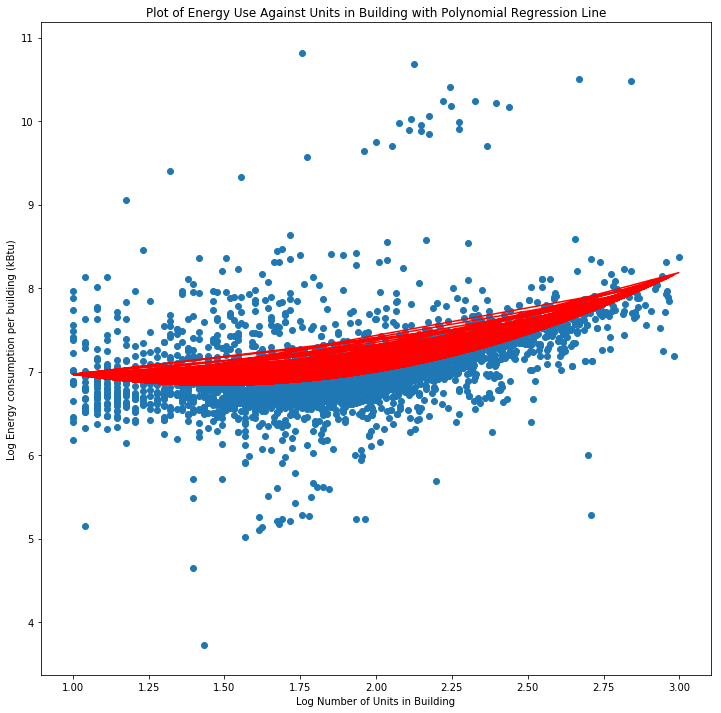

In [103]:
fitted_plot = pl.figure(figsize=(12,12))
ax = fitted_plot.add_subplot(111)
ax.scatter(bblnrgdataCut['log_units'],bblnrgdataCut['log_energy'])
ax.plot(bblnrgdataCut['log_units'],poly_model.predict(),'r')
ax.set_title("Plot of Energy Use Against Units in Building with Polynomial Regression Line")
ax.set_xlabel("Log Number of Units in Building")
ax.set_ylabel("Log Energy consumption per building (kBtu)")